In [1]:
# @ copyright
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import dask.dataframe as dd

import gc
warnings.simplefilter('ignore')
matplotlib.rcParams['figure.dpi'] = 100
sns.set()
%matplotlib inline


### to save data or model
import pickle
import h5py


     The aim of this notebook is to provide investogation of the data sets
     as a first requirement for building a model. Note that there was computationally limited resources (using a    PC).So, I always think of the simplest and cost effective way to go about achieving a task 

### Loading the dataset


[If you have the various meter dataset then click here to Jump to Loading Data](#Load-Data)


<p> Note that the test data have been committed out but similar steps would be replicated for the test data. </p>

 The goal here is to prepare the training data set for
 training.

In [4]:
# read the training set
train = pd.read_csv('train.csv')
#test = pd.read_csv('test.csv')


In [4]:
# read the building data set
building = pd.read_csv('building_metadata.csv')


 Merging Train and building data sets that have been imported from above.
 
 

In [5]:
train = train.merge(building, on='building_id', how='left')
#test = test.merge(building, on='building_id', how='left')
#test.to_pickle('test_building')  # where to save it, usually as a .pkl

In [11]:
# Saving the data set as pickle file to enable easy loading of merged data set
# This also saves the cost of merging
train.to_pickle('train_building')  # where to save it, usually as a .pkl


# Merged Data Separation

Separate Data based on meter 


In [2]:
# load merged building and train data
mergerd = pd.read_pickle('train_building')

In [3]:
# load the weather data
weather_train = pd.read_csv('weather_train.csv')
#weather_test = pd.read_csv('weather_test.csv')

In [4]:
# the unique meter id in the data set
# we will partition the data set based on this
mergerd.meter.unique()

array([0, 3, 1, 2])

In [5]:
# meter zero data
meterZeroData = mergerd.loc[mergerd['meter'] == 0].copy(deep=True)

In [6]:
# meter one data
meterOneData = mergerd.loc[mergerd['meter'] == 1].copy(deep=True)


In [7]:
# meter 2 data
meterTwoData = mergerd.loc[mergerd['meter'] == 2].copy(deep=True)


In [8]:
# meter 3 data
meterThreeData = mergerd.loc[mergerd['meter'] == 3].copy(deep=True)


# Weather Data Integration


    Meter Zero merging and saving

In [9]:
# merged meter zero data to produce MeterZero_train-building-weather data set
meterZeroTrainData = meterZeroData.merge(weather_train, on=['site_id', 'timestamp'], how='left')


In [10]:
# uncomment if you dont want to load the pickle file
#del meterZeroData

In [27]:
# save data file as hdf5
meterZeroTrainData.to_csv('meterZeroTrainData.csv')

    Meter One merging and saving as HDF5 format

In [15]:
# merged meter one data to produce MeterOne_train-building-weather data set
meterOneTrainData = meterOneData.merge(weather_train, on=['site_id', 'timestamp'], how='left')


In [16]:
# uncomment if you dont want to load the pickle file
#del meterOneData

In [28]:
meterOneTrainData.to_csv('meterOneTrainData.csv')

    Meter Two Merging and saving as HDF5 format

In [18]:
# merged meter Two data to produce train-building-weather data set
meterTwoTrainData = meterTwoData.merge(weather_train, on=['site_id', 'timestamp'], how='left')


In [19]:
# uncomment if you dont want to load the pickle file
del meterTwoData

In [29]:
meterTwoTrainData.to_csv('meterTwoTrainData.csv')

    Meter Three Merging and saving as HDF5 format

In [21]:
# merged meter Three data to produce train-building-weather data set

meterThreeTrainData = meterThreeData.merge(weather_train, on=['site_id', 'timestamp'], how='left')


In [22]:
# uncomment if you dont want to load the pickle file
#del meterThreeData

In [30]:
meterThreeTrainData.to_csv('meterThreeTrainData.csv')

## Load Data 

In [32]:
# I will Load only the zero meter data set 
# same syntax applied for other data set
meterOneDataLOaded= pd.read_csv('meterOneTrainData.csv')
# all meter types data set could be analysed in same manner

In [33]:
# check the number of columns present in data set
meterOneDataLOaded.columns

Index(['Unnamed: 0', 'building_id', 'meter', 'timestamp', 'meter_reading',
       'site_id', 'primary_use', 'square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed'],
      dtype='object')

Let us investigate if it is possible to parition data based on meter, site_id and primary_use 

    1) We have to check the  unique elements present in each of the 3 columns named above

In [34]:
# unique elements  in the column 'primary_use
meterOneDataLOaded.primary_use.unique() 


array(['Education', 'Lodging/residential', 'Retail', 'Office',
       'Entertainment/public assembly', 'Food sales and service',
       'Public services', 'Healthcare', 'Utility', 'Other',
       'Technology/science', 'Parking', 'Manufacturing/industrial',
       'Religious worship'], dtype=object)

In [40]:
# remove unnmaed unnamed 0: column
del meterOneDataLOaded['Unnamed: 0']

In [35]:
# unique element in the column meter 
meterOneDataLOaded.meter.unique()

array([1])

In [36]:
# unique element in the column site id
meterOneDataLOaded.site_id.unique() # the numbers of site id present

array([ 2,  6,  7,  9, 10, 11, 13, 14, 15,  0])

<p> we observe that this will create a lot of smaller subset and it might not be possible to make a model for each
    of this (for computational limitation and flexibility reasons) </p>
    
Nevertheless we will proceed to see how the partitioning could be done

# Partitioning
    
    1) Primary_use column is an pandas object type (or say it is not a numeric value).
    2) Convert it to pandas category type and  assign a numeric value to each category. The category mappings              can be trivially retrieved in pandas
    3) Meter and site_id are both int64 type. Therefore nopthing to be done here
    4) It is possible to then use Multi index approach to index the data set on primery_use,
       meter and site_id
    5) However, let us use a simple approach. A new column will be added to the data set and it
       will be called separator. To achieve this convert meter, site_id, and primary_use to string data type.
    6) The column separator is defined as:
          separator  = meter + primary_use  + site_id
    7) Now we can select a subset or partition based on this selector. Data points belonging to the same
       separator value would share same meter id, primary use and site id.

In [37]:
## step 1 : convert pry_use to category set to 
meterOneDataLOaded["primary_use"] = meterOneDataLOaded["primary_use"].astype('category')

In [41]:
# check that primary use is of type category
# this step does not change the label for the contents of pimary  use
meterOneDataLOaded.dtypes # primary use is now a category

building_id              int64
meter                    int64
timestamp               object
meter_reading          float64
site_id                  int64
primary_use           category
square_feet              int64
year_built             float64
floor_count            float64
air_temperature        float64
cloud_coverage         float64
dew_temperature        float64
precip_depth_1_hr      float64
sea_level_pressure     float64
wind_direction         float64
wind_speed             float64
dtype: object

In [43]:
# encode each category as numeric values
meterOneDataLOaded["primary_use_encodings"] = meterOneDataLOaded["primary_use"].cat.codes


In [44]:
# cheeck the encodings oe mappings that have been assigned
meterOneDataLOaded.primary_use_encodings.unique() # the encodings

array([ 0,  4, 11,  6,  1,  2,  9,  3, 13,  7, 12,  8,  5, 10])

In [45]:
# Now step 5
# step 5 : convert meter from int64 to string
meterOneDataLOaded['meter']= meterOneDataLOaded['meter'].values.astype(np.str)

In [46]:
# convert site_id to string too
meterOneDataLOaded['site_id']= meterOneDataLOaded['site_id'].values.astype(np.str) 

In [47]:
# convert pry use  to string
meterOneDataLOaded['primary_use_encodings']= meterOneDataLOaded['primary_use_encodings'].values.astype(np.str)

In [49]:
# step 6 : separator column defined here 
meterOneDataLOaded['separator'] =  meterOneDataLOaded['site_id']+ meterOneDataLOaded['primary_use_encodings']

In [50]:
unique_partition = meterOneDataLOaded.separator.unique()

In [51]:
# these are the unique partions or groups available
# it is very diffcult to create a model for each of these
# read this as 000: meter 0 , site 0, primary use 0 (education)
# 004 : meter 0 , site id 0, pry use 4 (Lodging/residential)
# to get the mapping of pry use check next cell
unique_partition

array(['20', '24', '211', '26', '21', '22', '29', '23', '213', '60', '61',
       '64', '70', '96', '94', '90', '91', '99', '100', '107', '1012',
       '110', '134', '133', '136', '131', '130', '139', '138', '146',
       '140', '149', '143', '142', '141', '144', '156', '150', '1512',
       '155', '1510', '154', '151', '159', '153', '66', '69', '00', '06',
       '011', '07', '04'], dtype=object)

In [52]:
len(unique_partition) # 52 partitions

52

#### Mappings for primary use

In [53]:
 # store the encodings/numbers  of the pry use
labels = meterOneDataLOaded.primary_use.unique() #munique elements of the sites (how many sites we have)


In [55]:
# for each number retrieve its category and store as tuple in a list

category_mappings=[] # list for storing number and cateogory pair
for i in labels:
    temp = meterOneDataLOaded.primary_use.cat.categories.get_loc(i) # retrieve the category given the number
    category_mappings.append((temp,i)) # store the mappings
    

In [56]:
# check all the mappings categories
category_mappings 

[(0, 'Education'),
 (4, 'Lodging/residential'),
 (11, 'Retail'),
 (6, 'Office'),
 (1, 'Entertainment/public assembly'),
 (2, 'Food sales and service'),
 (9, 'Public services'),
 (3, 'Healthcare'),
 (13, 'Utility'),
 (7, 'Other'),
 (12, 'Technology/science'),
 (8, 'Parking'),
 (5, 'Manufacturing/industrial'),
 (10, 'Religious worship')]

# Further Details

If we have 0112, it might be difficult to know whether the site id is 1 and category is 12 or vice versa.
So, I have decided to convert site id to alphabets to remove this ambiguity.
The result of this is same as when site id is not chneged but this is easier to read.

In [57]:
# Site_id as Alphabets
meterOneDataLOaded["site_id"] = meterOneDataLOaded["site_id"].astype('category')


In [52]:
#siteIdUnique = train["site_id"].unique()

In [64]:
 # this is what site id will be mapped to
newSiteName = ['a','b','c','d','e','f','g','h','i','j']
# change site id to category.and assign the mapping from the list aboce
meterOneDataLOaded.site_id.cat.rename_categories(newSiteName,inplace=True)

In [65]:
# site id was chneged to str for concatenation
meterOneDataLOaded['site_id']= meterOneDataLOaded['site_id'].values.astype(np.str) # convert siteid back to string

In [66]:
# delete previous separator
del meterOneDataLOaded['separator']

In [68]:
# make new separator column
meterOneDataLOaded['separator'] =  meterOneDataLOaded['site_id']+ meterOneDataLOaded['primary_use_encodings']

In [69]:
# check the unique separator values which corresponds to the partiton
separator = meterOneDataLOaded.separator.unique()

In [70]:
# check the partition
separator

array(['g0', 'g4', 'g11', 'g6', 'g1', 'g2', 'g9', 'g3', 'g13', 'h0', 'h1',
       'h4', 'i0', 'j6', 'j4', 'j0', 'j1', 'j9', 'b0', 'b7', 'b12', 'c0',
       'd4', 'd3', 'd6', 'd1', 'd0', 'd9', 'd8', 'e6', 'e0', 'e9', 'e3',
       'e2', 'e1', 'e4', 'f6', 'f0', 'f12', 'f5', 'f10', 'f4', 'f1', 'f9',
       'f3', 'h6', 'h9', 'a0', 'a6', 'a11', 'a7', 'a4'], dtype=object)

In [71]:
len(separator) # total groups

52

Number of Buildings by Primary Use:


Text(0,0.5,'Number of Buildings')

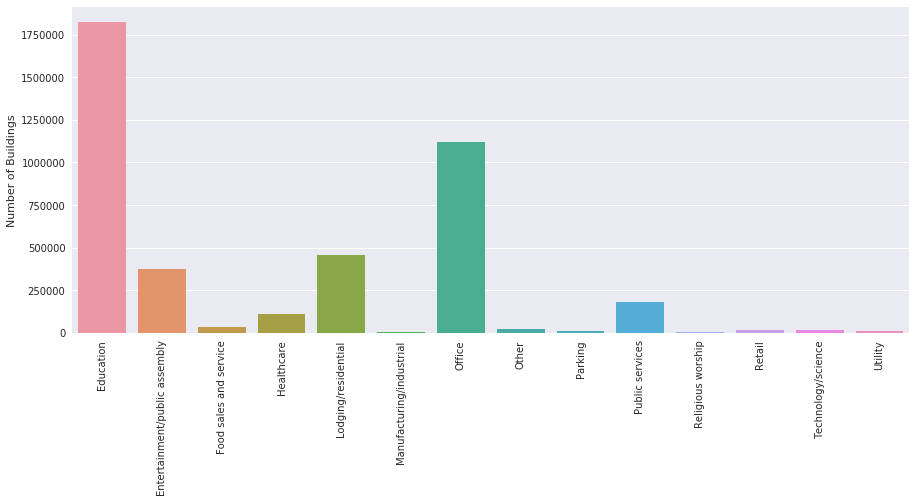

In [73]:
building_count = meterOneDataLOaded.primary_use.value_counts()
print('Number of Buildings by Primary Use:')
plt.figure(figsize=(15,6))
sns.barplot(building_count.index,meterOneDataLOaded.primary_use.value_counts())
plt.xticks(rotation = 90)
plt.ylabel('Meter One : Number of Buildings')

In [38]:
# to retieve a particular partition use the syntax below
# I ran out of memory here so I cant run to show sample results
# train.query('separator == "0f1"')[1:2]
# train.loc[train['separator'] == '0f1'][1:2]

### Conclusion

Analysis based on meter dataset partition could give better insight: the various peculiarities of the meter type could be easily visualised to give details about energy consumption. Some meter might not be present in some site while some site id  might show preference for certain primary use. This is meant as introduction to further investigation.
Now the cleaned data set is available for further analysis